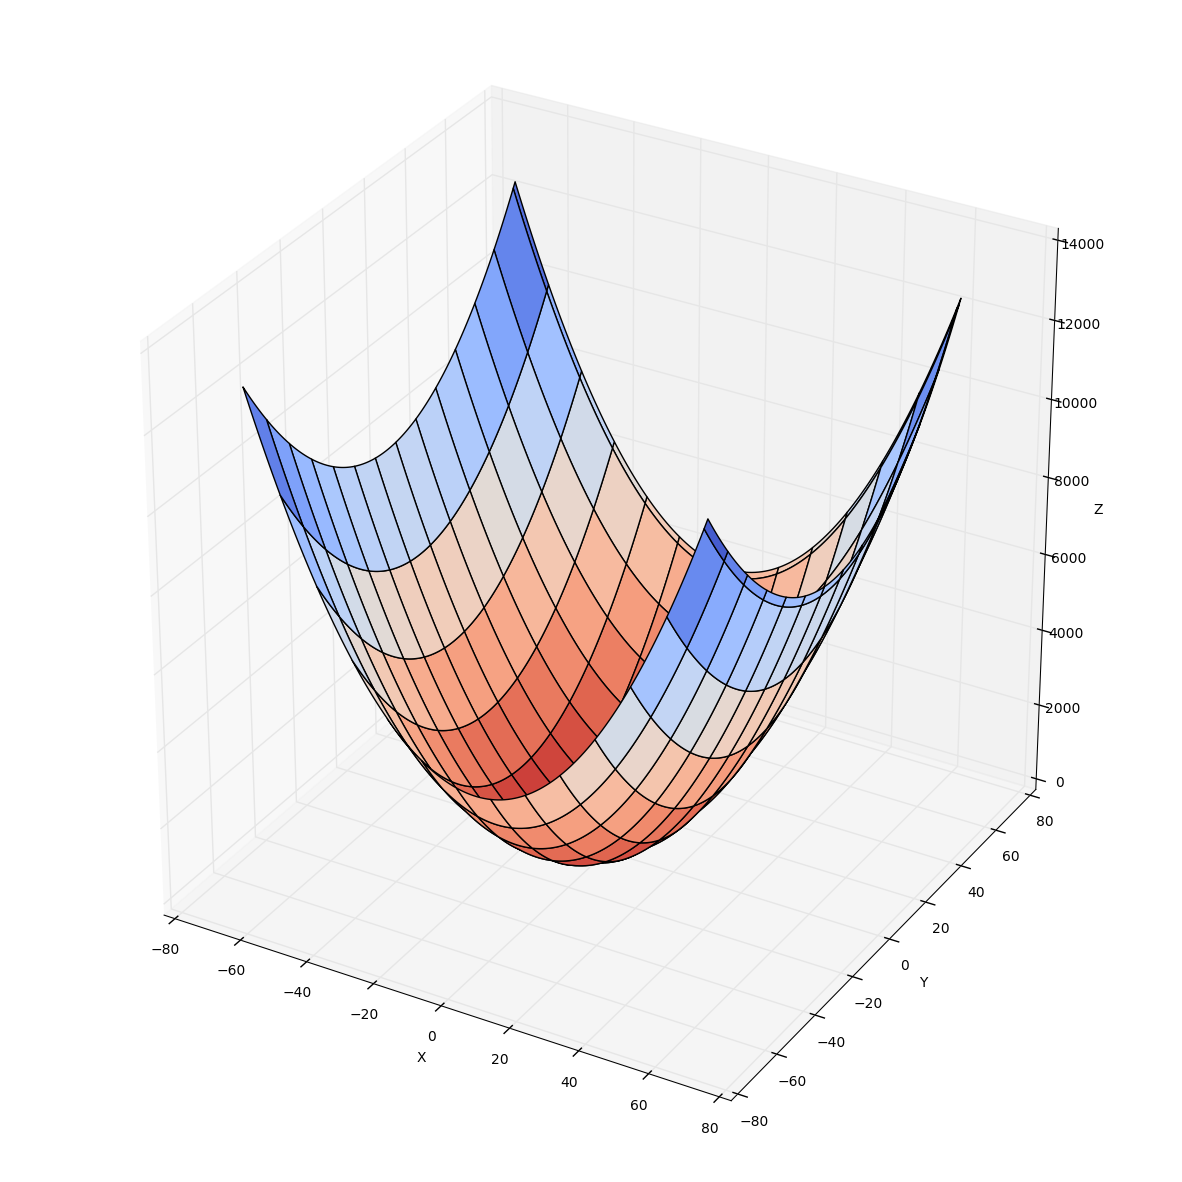

In [19]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import math 
from matplotlib import cm

def hiper_elipsoide_rotado(coords):
    result = 0
    for i in range(1, len(coords)+1):
        for j in range(1, i+1):
            result += coords[j-1]**2
    return result

x = y = np.arange(-65.54 , 65.54 , 1)
X, Y = np.meshgrid(x, y)
z = np.array([hiper_elipsoide_rotado([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_figwidth(15)
fig.set_figheight(15)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)

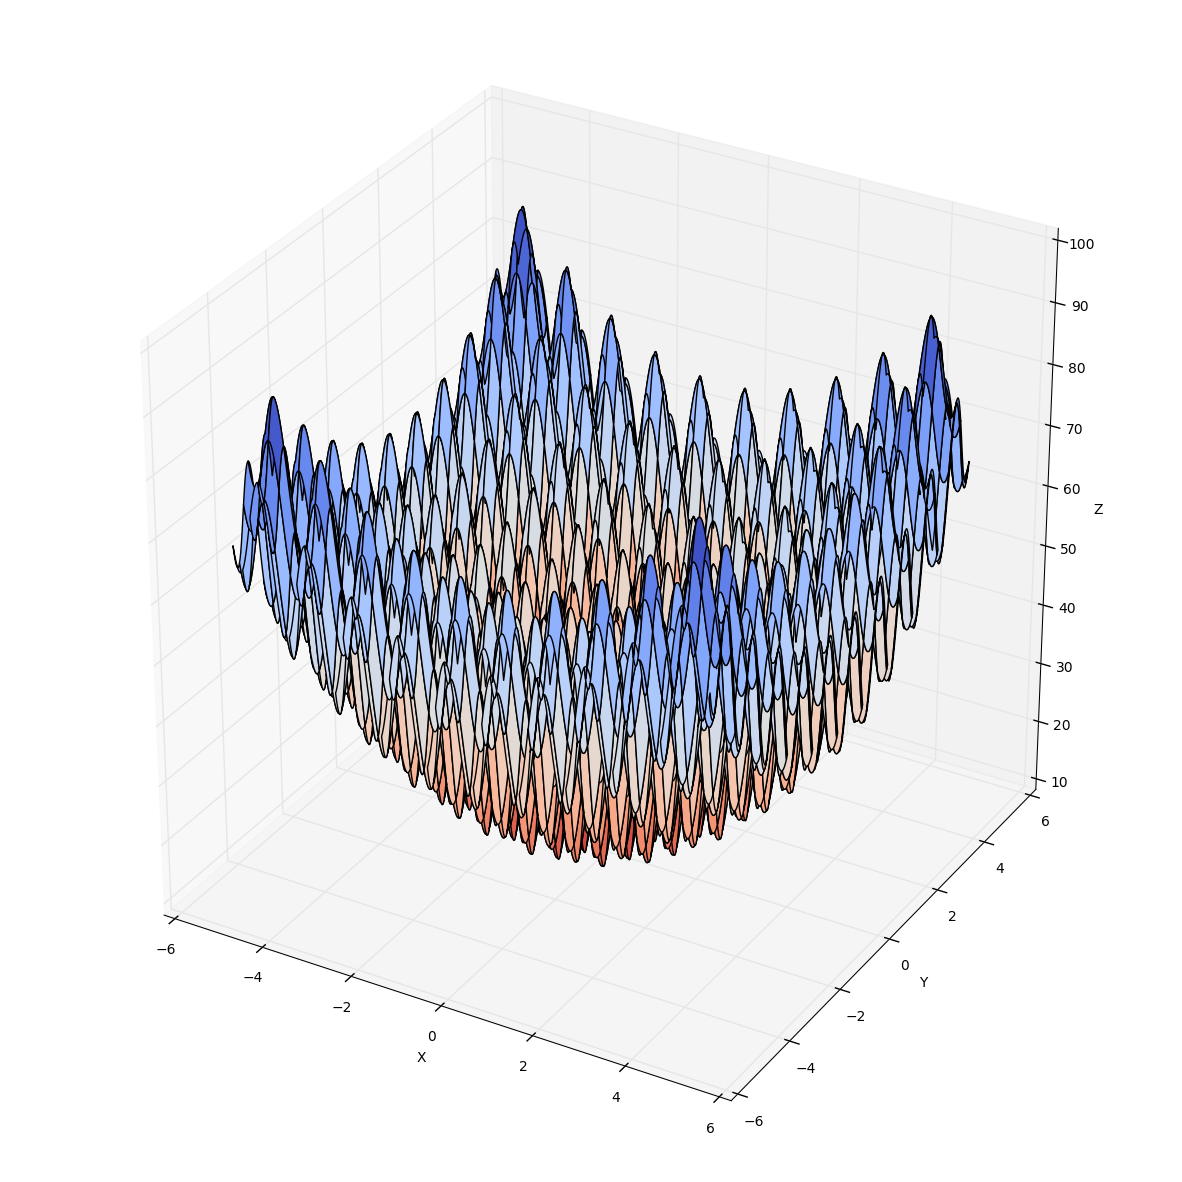

In [18]:
def rastrigin(coords):
    result = 0
    n=len(coords)+1
    for i in range(1, n):
        xi=coords[i-1]
        result += xi**2 - 10*math.cos(2*math.pi*xi)
    return 10*n + result

x = y = np.arange(-5.12 , 5.12 , 0.02)
X, Y = np.meshgrid(x, y)
z = np.array([rastrigin([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_figwidth(15)
fig.set_figheight(15)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)